# CycleGAN for SVHN --> MNIST transfer
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for transforming the SVHN domain to the MNIST one

In [48]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets
from torchvision import transforms

from IPython.display import clear_output

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [3]:
def normalize(x, max_value):
    """ Normalize the input between -1 and 1 """
    return (x / float(max_value)) * 2 - 1

### SVHN

In [4]:
svhn = datasets.SVHN(root="/home/arthur/datasets/svhn", download=False)

In [5]:
X_svhn = svhn.data
X_svhn = np.transpose(X_svhn, (0,2,3,1))
Y_svhn = svhn.labels.flatten()%10
X_svhn.shape

(73257, 32, 32, 3)

### MNIST

In [6]:
mnist = input_data.read_data_sets('/home/arthur/datasets/mnist', one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
X_mnist = mnist.train.images
X_mnist = X_mnist.reshape(len(X_mnist), 28, 28, 1)
Y_mnist = mnist.train.labels
X_mnist.shape

(55000, 28, 28, 1)

In [8]:
X_source = X_svhn
X_target = X_mnist

## Create the model

### Useful functions

In [9]:
def leaky_relu(x):
    alpha = 0.2
    return tf.maximum(x, alpha * x)

In [10]:
def instance_normalization(x, name):
    with tf.variable_scope("instance_norm"):
        with tf.variable_scope(name):
            epsilon = 1e-5
            mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
            scale = tf.get_variable('scale',[x.get_shape()[-1]], 
                initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
            offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
            out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

            return out

In [11]:
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

### Placeholders

In [12]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_source')
ipt_source_transf = normalize(tf.image.rgb_to_grayscale(ipt_source), 256)

ipt_target = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='ipt_target')
ipt_target_transf = normalize(tf.image.resize_images(ipt_target, [32, 32]), 1)

### Discriminator Network

In [13]:
def discriminator(x): 
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope("discriminator"):
        # Layer 1: 32x32xn --> 16x16x32 (n=1 or 3)
        x_noisy = gaussian_noise_layer(x, 0.4)
        conv1 = tf.layers.conv2d(x_noisy, 32, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: 16x16x32 --> 8x8x16        
        conv2 = tf.layers.conv2d(conv1, 16, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x16 --> 4x4x8     
        conv3 = tf.layers.conv2d(conv2, 8, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")

        # Layer 3: 128 --> 64
        fc1 = tf.contrib.layers.flatten(conv3)
        fc1 = tf.layers.dense(inputs=fc1, units=32, activation=leaky_relu, kernel_initializer=initializer)
    
        # Layer 4: Input 64. Output 32
        fc2 = tf.layers.dense(inputs=fc1, units=16, activation=leaky_relu, kernel_initializer=initializer)
        
        # Layer 5: Input 32. Output 1
        fc3 = tf.layers.dense(inputs=fc2, units=1, activation=None, kernel_initializer=initializer)
    
    return fc3

### Generator Network

In [14]:
def generator(x):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=None):
        # Layer 1: 32x32x1 --> 16x16x32
        conv1 = tf.layers.conv2d(x, 64, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: 16x16x32 --> 8x8x16
        conv2 = tf.layers.conv2d(conv1, 32, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x16 --> 4x4x8
        conv3 = tf.layers.conv2d(conv2, 16, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")

        # Layer 4: 4x4x8 --> 8x8x16
        deconv1 = tf.layers.conv2d_transpose(conv3, 32, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 5: 8x8x16 --> 16x16x32
        deconv2 = tf.layers.conv2d_transpose(deconv1, 64, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = instance_normalization(deconv2, "deconv2")
        
        # Layer 6: 16x16x32 --> 32x32x1
        deconv3 = tf.layers.conv2d_transpose(deconv2, 1, [5, 5], strides=2, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)

    return deconv3

### Losses and solver

#### Useful functions

In [15]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

#### Define the graph

In [16]:
with tf.variable_scope("s2t") as scope:
    D_target = discriminator(ipt_target_transf)
    G_target = generator(ipt_source_transf)
    scope.reuse_variables()
    DG_target = discriminator(G_target)

In [17]:
with tf.variable_scope("t2s") as scope:
    D_source = discriminator(ipt_source_transf)
    G_source = generator(ipt_target_transf)
    scope.reuse_variables()
    DG_source = discriminator(G_source)

In [18]:
with tf.variable_scope("s2t", reuse=True) as scope:
    cyc_target = generator(G_source)

In [19]:
with tf.variable_scope("t2s", reuse=True) as scope:
    cyc_source = generator(G_target)

#### Losses

In [20]:
lambda_cyc = 5

In [21]:
cyc_loss = tf.losses.mean_squared_error(ipt_source_transf, cyc_source) + tf.losses.mean_squared_error(ipt_target_transf, cyc_target)
tf.summary.scalar("cyc_loss", cyc_loss)

<tf.Tensor 'cyc_loss:0' shape=() dtype=string>

In [22]:
D_s2t_loss = tf.reduce_mean(DG_target) - tf.reduce_mean(D_target)
G_s2t_loss = -tf.reduce_mean(DG_target) + lambda_cyc*cyc_loss

tf.summary.scalar("D_s2t_loss", D_s2t_loss)
tf.summary.scalar("G_s2t_loss", G_s2t_loss)

<tf.Tensor 'G_s2t_loss:0' shape=() dtype=string>

In [23]:
D_t2s_loss = tf.reduce_mean(DG_source) - tf.reduce_mean(D_source)
G_t2s_loss = -tf.reduce_mean(DG_source) + lambda_cyc*cyc_loss
tf.summary.scalar("D_t2s_loss", D_t2s_loss)
tf.summary.scalar("G_t2s_loss", D_t2s_loss)

<tf.Tensor 'G_t2s_loss:0' shape=() dtype=string>

#### Solvers

In [24]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/discriminator')
G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/generator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/discriminator')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/generator')

In [25]:
D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(D_s2t_loss, var_list=D_s2t_vars)
G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(G_s2t_loss, var_list=G_s2t_vars)
D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(D_t2s_loss, var_list=D_t2s_vars)
G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(G_t2s_loss, var_list=G_t2s_vars)

In [26]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_t2s_vars]

## Run the model

In [27]:
sess = tf.InteractiveSession()

In [28]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
cyc_loss_list = []
iter_list = []
i = 0

In [29]:
saver = tf.train.Saver()
saver.restore(sess, "model/model.ckpt")

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [92]:
###!!!!! TODO : pretrain MNIST --> SVHN as an autoencoder !!!!! ###

nb_iter = 100
nb_iter_d = 10
nb_iter_g = 1
nb_samples = 3000
G_s2t_loss_curr = 0.001
D_s2t_loss_curr = 0.001
G_t2s_loss_curr = 0.001
D_t2s_loss_curr = 0.001
cyc_loss_curr = 0.001
verbose = True

i_init = i
for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        # Optimizing s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        # Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s], feed_dict={ipt_source: sample_source, ipt_target: sample_target})

    iter_list.append(i)
    cyc_loss_curr, = sess.run([cyc_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    cyc_loss_list.append(cyc_loss_curr)
    
    if verbose:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('Cycle-loss: {:.4}'.format(cyc_loss_curr))
        print()
    
    if i % (nb_iter//5) == 0:
#         summary = sess.run([merged_summary], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
#         summary_writer.add_summary(summary, i)
        saver.save(sess, "model.ckpt")
        
        
        
# summary_writer.flush()

Iter: 342 / 343
D loss s2t: -1.07
D loss t2s: -2.239
G loss s2t: 2.222
G loss t2s: 5.258
Cycle-loss: 0.2266



## Display the results

In [93]:
def unnormalize(x):
    return (x + 1)/2

In [94]:
X_source_trans = unnormalize(sess.run(G_target, feed_dict={ipt_source: X_source[:50]}))
X_target_trans = unnormalize(sess.run(G_source, feed_dict={ipt_target: X_target[:50]}))
X_source_cyc = unnormalize(sess.run(cyc_source, feed_dict={ipt_source: X_source[:50]}))
X_target_cyc = unnormalize(sess.run(cyc_target, feed_dict={ipt_target: X_target[:50]}))

(-0.5, 31.5, 31.5, -0.5)

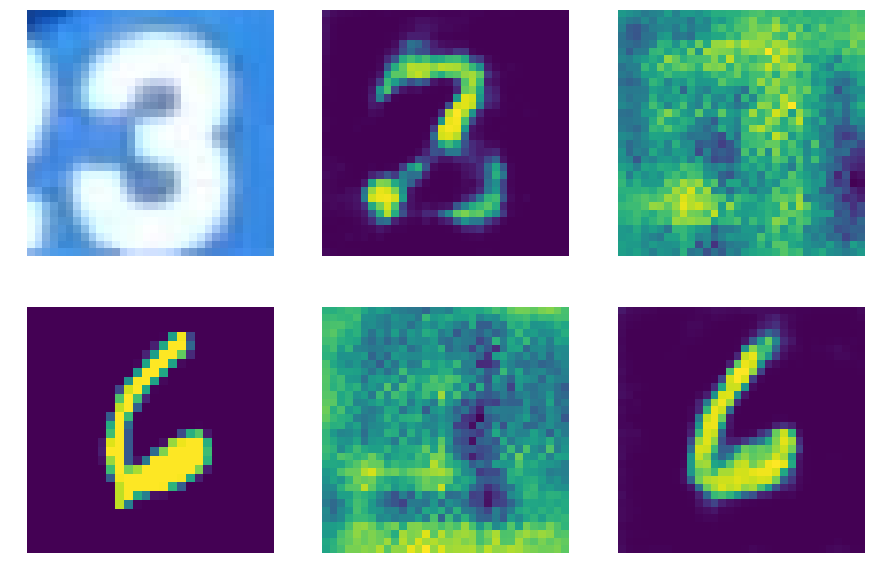

In [89]:
plt.rcParams['figure.figsize'] = (15, 10)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 3
plt.subplot(2,3,1)
plt.imshow(X_svhn[index])
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(X_source_trans[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(X_source_cyc[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(unnormalize(X_target[index].reshape(28,28)))
plt.axis('off')

plt.subplot(2,3,5)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_trans[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,6)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_cyc[index].reshape(32,32))
plt.axis('off')

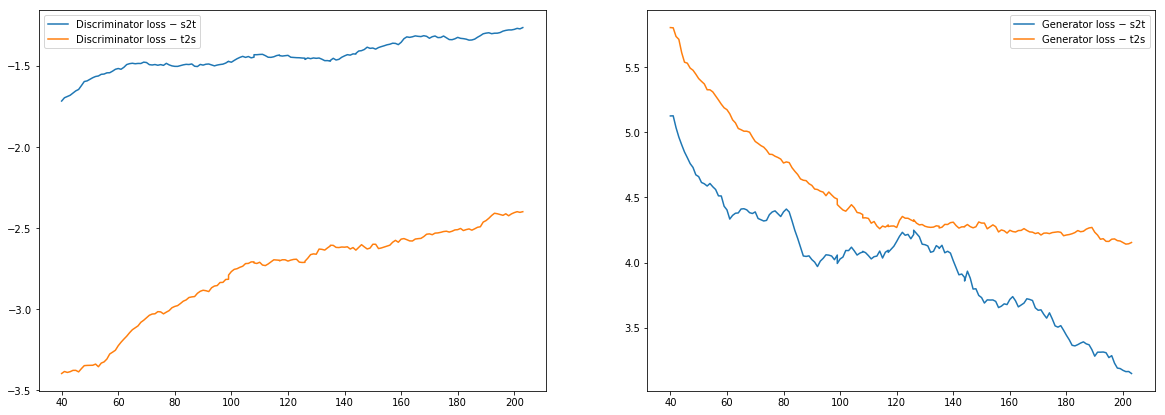

In [90]:
k = 40
def smooth(x_list):
    return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k:-k], smooth(D_s2t_loss_list), label="Discriminator loss − s2t")
plt.plot(iter_list[k:-k], smooth(D_t2s_loss_list), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k:-k], smooth(G_s2t_loss_list), label="Generator loss − s2t")
plt.plot(iter_list[k:-k], smooth(G_t2s_loss_list), label="Generator loss − t2s")
plt.legend()

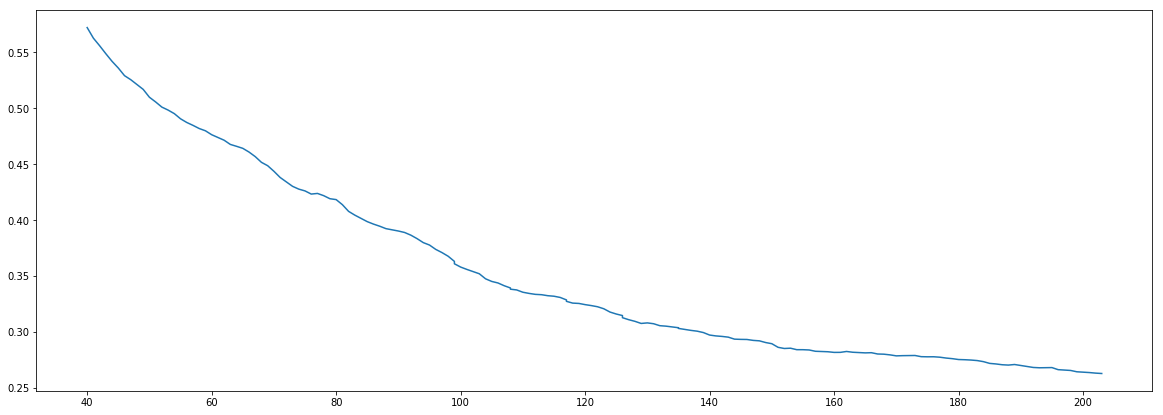

In [91]:
plt.plot(iter_list[k:-k], smooth(cyc_loss_list), label="Cycle loss")

## Debug

In [ ]:
#X_target_trans[10][:,:,:]

### Gradients

In [ ]:
ind = 1
print("Gradient with respect to", D_s2t_vars[ind])
gradient = sess.run(tf.gradients(D_s2t_loss, D_s2t_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 10
print("Gradient with respect to", D_t2s_vars[ind])
gradient = sess.run(tf.gradients(D_t2s_loss, D_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 10
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
D_s2t_vars[ind]

In [ ]:
D_s2t_vars

In [ ]:
X_test = sess.run([ipt_target_transf], feed_dict={ipt_source: sample_source, ipt_target: sample_target})[0][5]

In [ ]:
plt.imshow(X_test[:,:,0])